In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import time
import yfinance as yf

### Using Monte-Carlo method for finding optimal Sharpe ratios in cryptocurrency portfolios

First, we'll use the yahoo finance API to get stock price data for four coins--bitcoin, ethereum, litecoin, and ripple

In [2]:
coins = [
    'BTC-USD',
    'ETH-USD',
    'LTC-USD',
    'XRP-USD',
    ]

In [3]:
def get_data(tickers):
    """Read in daily price(adjusted close) of asset for a given set of dates."""
        
    # download daily price data for each of the stocks in the portfolio
    df = yf.download(tickers)['Adj Close']
    
    return df.dropna()

In [4]:
crypto_prices = get_data(coins)
print(crypto_prices.head())

[*********************100%***********************]  4 of 4 completed
               BTC-USD   ETH-USD  LTC-USD   XRP-USD
Date                                               
2015-08-07  279.584991  2.772120  4.20828  0.008152
2015-08-08  260.997009  0.753325  3.85475  0.008476
2015-08-09  265.083008  0.701897  3.89859  0.008808
2015-08-10  264.470001  0.708448  3.94888  0.008750
2015-08-11  270.385986  1.067860  4.15955  0.008591


#### Next, we'll define a function for calculating daily returns for our coins

In [5]:
def calc_daily_returns(df):
    return (df.pct_change())

In [6]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

             BTC-USD   ETH-USD   LTC-USD   XRP-USD
Date                                              
2015-08-07       NaN       NaN       NaN       NaN
2015-08-08 -0.066484 -0.728250 -0.084008  0.039745
2015-08-09  0.015655 -0.068268  0.011373  0.039169
2015-08-10 -0.002313  0.009333  0.012900 -0.006585
2015-08-11  0.022369  0.507323  0.053349 -0.018171


#### Define a function for calculating mean daily returns for our coins

In [7]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [8]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

BTC-USD    0.003394
ETH-USD    0.005395
LTC-USD    0.003450
XRP-USD    0.004506
dtype: float64


#### Define a function for creating covariance matrices

In [9]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [10]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

          BTC-USD   ETH-USD   LTC-USD   XRP-USD
BTC-USD  0.001554  0.001256  0.001434  0.000990
ETH-USD  0.001256  0.004219  0.001743  0.001403
LTC-USD  0.001434  0.001743  0.003256  0.001696
XRP-USD  0.000990  0.001403  0.001696  0.006266


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins

In [11]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(len(tickers)))

        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # Create initial column list
    column_list = [
        'ret',
        'stdev',
        'sharpe',
    ]

    # Add each ticker as a column
    for i in range(len(tickers)):
        {
            column_list.append(tickers[i])
        }

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=column_list)
    
    return results_df

In [12]:
crypto_results = create_results_dataframe(coins, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.085144  0.722274  1.483155  0.230650  0.315501  0.211816  0.242033
1  1.077199  0.748789  1.420024  0.179246  0.257561  0.247084  0.316109
2  1.134389  1.014362  1.104624  0.101379  0.140357  0.015804  0.742460
3  1.081987  0.755426  1.413888  0.105509  0.363503  0.395793  0.135195
4  0.931496  0.641691  1.429965  0.575648  0.043344  0.196759  0.184249


#### Define a function to find the portfolio with the highest sharpe ratio 

In [13]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [14]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.034788
stdev      0.645591
sharpe     1.581322
BTC-USD    0.577080
ETH-USD    0.274092
LTC-USD    0.001308
XRP-USD    0.147520
Name: 598, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [15]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [16]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        0.900194
stdev      0.613007
sharpe     1.445814
BTC-USD    0.820481
ETH-USD    0.030916
LTC-USD    0.046042
XRP-USD    0.102560
Name: 1124, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with the highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [17]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


<ipython-input-17-573cf41c9e1e>:4: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, color='w', linestyle='-', linewidth=1)


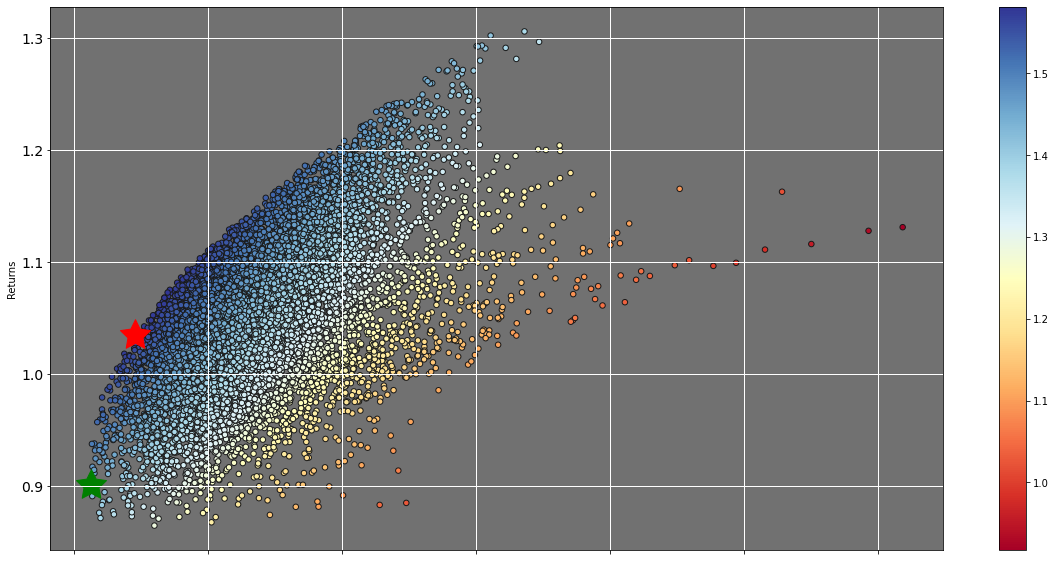

In [18]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()